# LASSO-BBN

Notes

- dm is response variable

Drop these variables
- Vlr 
- bs15
- TestTrain
- id

Algorithm

- dm ~ bs01lr + bs02lr + ... + bs19lr
- bs01lr ~ bs02lr + ... + bs19lr
- bs07lr ~ bs09lr + .... + bs11lr

What to do about missing values?

- use 1.0 since these are likelihood ratios
- use 0.0 because that might be the right thing to do; but scale data to [0, 1] range before regression
- imputation? 

TODO

- no need to do robust yet
- recursive LASSO
- induce BBN structure
- create parameters
- export graph to show mediations

In [1]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('s3://jeeforce-artifacts/alemi/diabetes/BodySystemTrainTable.csv', low_memory=False)
raw_df.shape

(2063013, 23)

In [2]:
df = raw_df.drop(columns=['id', 'Vlr', 'bs15lr', 'TestTrain']) \
    .rename(columns={
        'bs1lr': 'bs01lr',
        'bs2lr': 'bs02lr',
        'bs3lr': 'bs03lr',
        'bs4lr': 'bs04lr',
        'bs5lr': 'bs05lr',
        'bs6lr': 'bs06lr',
        'bs7lr': 'bs07lr',
        'bs8lr': 'bs08lr',
        'bs9lr': 'bs09lr'
    })
df.shape

(2063013, 19)

In [38]:
df.isna().sum()

dm              0
bs01lr    1728725
bs02lr    1584907
bs03lr     781920
bs04lr    1798421
bs05lr     988523
bs06lr     899715
bs07lr     795886
bs08lr    1375571
bs09lr    1250320
bs10lr    1422029
bs11lr    2060940
bs12lr    1558015
bs13lr     854697
bs14lr    2013741
bs16lr     765461
bs17lr    1653390
bs18lr    1901535
bs19lr     118312
dtype: int64

In [39]:
df.iloc[0]

dm        1.000000
bs01lr         NaN
bs02lr         NaN
bs03lr    1.645058
bs04lr         NaN
bs05lr    1.195137
bs06lr         NaN
bs07lr    1.213059
bs08lr         NaN
bs09lr    1.960372
bs10lr         NaN
bs11lr         NaN
bs12lr         NaN
bs13lr         NaN
bs14lr         NaN
bs16lr    1.520102
bs17lr         NaN
bs18lr         NaN
bs19lr         NaN
Name: 0, dtype: float64

In [26]:
order_df = pd.read_csv('s3://jeeforce-artifacts/alemi/diabetes/ordering.csv') \
    .query('code != "rare_disease"')
order_df

,name,code,coefficient
0,Infectious_and_parasitic_diseases,bs01lr,0.000116
1,Diseases_of_the_circulatory_system,bs07lr,0.000112
2,"Endocrine,nutritional_and_metabolic diseases_a...",bs03lr,0.000112
3,Mental_disorders,bs05lr,0.000112
4,Diseases_of_the_digestive_system,bs09lr,0.000111
5,Diseases_of_the_respiratory_system,bs08lr,0.000110
6,Neoplasms,bs02lr,0.000110
7,Diseases_of_the_musculoskeletal_system_and_con...,bs13lr,0.000110
8,V_codes,bs19lr,0.000109
9,Diseases_of_the_nervous_system_and_sense_organs,bs06lr,0.000108


In [92]:
def get_order(code):
    r = order_df[order_df['code']==code].iloc[0]
    c = r['coefficient']
    codes = list(order_df[order_df['coefficient'] > c]['code'])
    return codes

order_map = {code: get_order(code) for code in order_df['code']}
order_map = {**order_map, **{'dm': list(order_df['code'])}}

In [112]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
import time

def log_time(y_field, t0, t1):
    diff = t1 - t0
    diff = diff / 60
    print(f'\t{y_field} @ {diff:.1} minutes')
    
def get_coef(model, X):
    return pd.Series(model.coef_[0], index=X.columns) \
        .to_frame(name='coefficient') \
        .reset_index() \
        .rename(columns={'index': 'field'}) \
        .assign(abs_coefficient=lambda d: np.abs(d['coefficient'])) \
        .sort_values(['abs_coefficient'], ascending=False) \
        .reset_index(drop=True)
    
def do_learn(df, y_field, one_threshold=0.8, C=0.01, tol=0.001):
    print(f'{y_field}')
    
    X = df[[c for c in df.columns if c in order_map[y_field]]].fillna(1.0)
    y = df[y_field]
    
    if y_field != 'dm':
        y = (expit(y.fillna(1.0)) > one_threshold).astype(int)
    
    print(f'\t{X.shape}, {y.shape}')
    if X.shape[0] == 0 or X.shape[1] == 0:
        return np.nan
    
    t0 = time.time()
    
    model = LogisticRegression(
        penalty='l1', 
        C=C, 
        max_iter=5_000, 
        tol=tol, 
        n_jobs=-1, 
        solver='saga')
    model.fit(X, y)
    
    t1 = time.time()
    log_time(y_field, t0, t1)
    
    return get_coef(model, X)

results = {y_field: do_learn(df, y_field) for y_field in order_map}

bs01lr
	(2063013, 0), (2063013,)
bs07lr
	(2063013, 1), (2063013,)
	bs07lr @ 0.08 minutes
bs03lr
	(2063013, 2), (2063013,)
	bs03lr @ 0.05 minutes
bs05lr
	(2063013, 3), (2063013,)
	bs05lr @ 0.06 minutes
bs09lr
	(2063013, 4), (2063013,)
	bs09lr @ 0.07 minutes
bs08lr
	(2063013, 5), (2063013,)
	bs08lr @ 0.07 minutes
bs02lr
	(2063013, 6), (2063013,)
	bs02lr @ 0.1 minutes
bs13lr
	(2063013, 7), (2063013,)
	bs13lr @ 0.08 minutes
bs19lr
	(2063013, 8), (2063013,)
	bs19lr @ 0.2 minutes
bs06lr
	(2063013, 9), (2063013,)
	bs06lr @ 0.7 minutes
bs10lr
	(2063013, 10), (2063013,)
	bs10lr @ 0.9 minutes
bs16lr
	(2063013, 11), (2063013,)
	bs16lr @ 0.9 minutes
bs12lr
	(2063013, 12), (2063013,)
	bs12lr @ 2e+00 minutes
bs04lr
	(2063013, 13), (2063013,)
	bs04lr @ 8e+00 minutes
bs17lr
	(2063013, 14), (2063013,)
	bs17lr @ 1e+01 minutes
bs18lr
	(2063013, 15), (2063013,)
	bs18lr @ 4e+00 minutes
bs14lr
	(2063013, 16), (2063013,)
	bs14lr @ 4e+00 minutes
bs11lr
	(2063013, 17), (2063013,)
	bs11lr @ 4e+00 minutes
dm
	(2

In [113]:
def get_parents(key, zero_threshold=0.09):
    try:
        temp_df = results[key]
        temp_df = temp_df[temp_df['abs_coefficient'] > zero_threshold]
        return list(temp_df['field'])
    except:
        return []
    
parents = {ch: get_parents(ch) for ch in results}
parents

{'bs01lr': [],
 'bs07lr': ['bs01lr'],
 'bs03lr': ['bs07lr'],
 'bs05lr': ['bs01lr', 'bs03lr'],
 'bs09lr': ['bs01lr', 'bs05lr', 'bs07lr', 'bs03lr'],
 'bs08lr': ['bs01lr', 'bs09lr', 'bs05lr', 'bs07lr', 'bs03lr'],
 'bs02lr': ['bs09lr', 'bs01lr', 'bs08lr', 'bs03lr'],
 'bs13lr': ['bs01lr', 'bs08lr', 'bs09lr', 'bs05lr', 'bs03lr', 'bs02lr'],
 'bs19lr': ['bs02lr',
  'bs07lr',
  'bs08lr',
  'bs01lr',
  'bs13lr',
  'bs09lr',
  'bs05lr',
  'bs03lr'],
 'bs06lr': ['bs13lr',
  'bs01lr',
  'bs08lr',
  'bs02lr',
  'bs09lr',
  'bs05lr',
  'bs03lr'],
 'bs10lr': ['bs01lr',
  'bs08lr',
  'bs02lr',
  'bs09lr',
  'bs13lr',
  'bs06lr',
  'bs05lr',
  'bs03lr'],
 'bs16lr': ['bs08lr',
  'bs01lr',
  'bs06lr',
  'bs09lr',
  'bs13lr',
  'bs07lr',
  'bs02lr',
  'bs05lr',
  'bs03lr'],
 'bs12lr': ['bs01lr',
  'bs02lr',
  'bs13lr',
  'bs08lr',
  'bs06lr',
  'bs09lr',
  'bs03lr'],
 'bs04lr': ['bs08lr', 'bs09lr', 'bs01lr', 'bs12lr', 'bs02lr', 'bs06lr'],
 'bs17lr': ['bs13lr',
  'bs12lr',
  'bs01lr',
  'bs09lr',
  'bs08lr'

In [114]:
import networkx as nx

g = nx.DiGraph()

for ch, pas in parents.items():
    for pa in pas:
        g.add_edge(pa, ch)

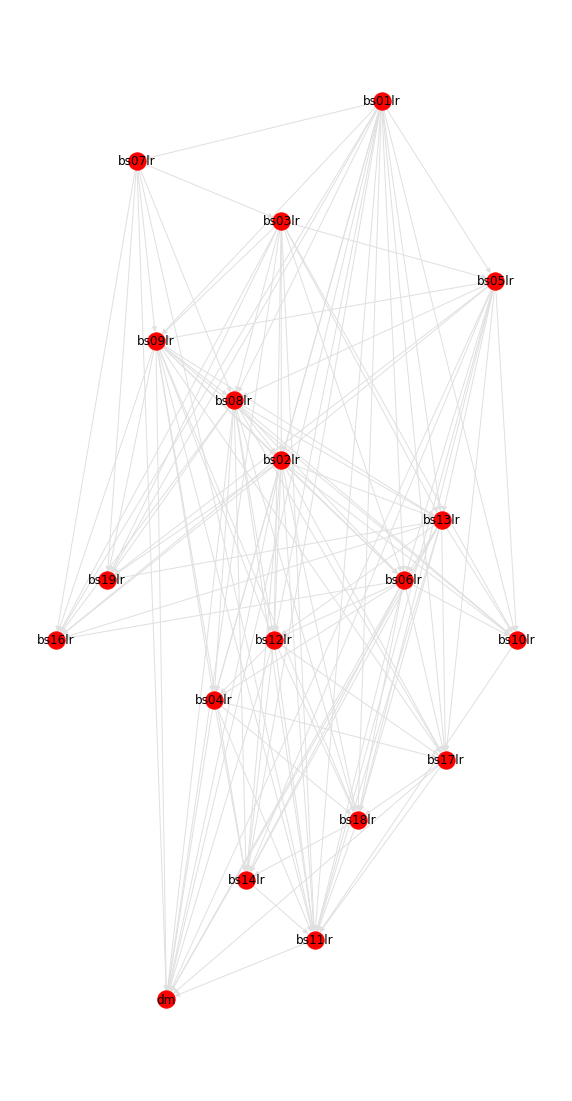

In [115]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

pos = graphviz_layout(g, prog='dot')

fig, ax = plt.subplots(figsize=(10, 20))
nx.draw(**{
        'G': g,
        'ax': ax,
        'pos': pos,
        'with_labels': True,
        'node_color': 'r',
        'edge_color': '#e0e0e0'
    })